##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


# 이미지 로드 및 전처리하기

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://www.tensorflow.org/tutorials/load_data/images"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서 보기</a>   </td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/tutorials/load_data/images.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행</a>   </td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/tutorials/load_data/images.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 소스 보기</a>   </td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/tutorials/load_data/images.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드</a></td>
</table>

이 튜토리얼은 두 가지 방법으로 이미지 데이터세트를 로드하고 전처리하는 방법을 보여줍니다. 먼저, 고급 Keras 전처리 [유틸리티](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) 및 [레이어](https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing)를 사용합니다. 다음으로 [tf.data](https://www.tensorflow.org/guide/data)를 사용하여 처음부터 자체 입력 파이프라인을 작성합니다.

## 설정

In [4]:
!pip install tensorflow_datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 10.7 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.1/98.1 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 kB 3.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.8/211.8 kB 5.5 MB/s eta 0:00:00
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21503 sha256=382f34858b88e98a0bdb4a501764897fcde69e2920cd00edcbafaea3aaba09a9
  Stored in directory: /Users/administrator/Library/Caches/pip/wheels/29/93/c6/762e359f8cb6a5b69c72235d798804cae523bbe41c2aa8333d
Successfully built promise


In [5]:
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds

In [6]:
print(tf.__version__)

2.7.0


### 꽃 데이터세트 다운로드하기

이 튜토리얼에서는 수천 장의 꽃 사진 데이터세트를 사용합니다. 꽃 데이터세트에는 클래스당 하나씩 5개의 하위 디렉토리가 있습니다.

```
flowers_photos/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

참고: 모든 이미지에는 CC-BY 라이선스가 있으며 크리에이터는 LICENSE.txt 파일에 나열됩니다.

In [7]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url, 
                                   fname='flower_photos', 
                                   untar=True)
data_dir = pathlib.Path(data_dir)

228827136/228813984 [==============================] - 21s 0us/step


다운로드한 후 (218MB), 이제 꽃 사진의 사본을 사용할 수 있습니다. 총 3670개의 이미지가 있습니다.

In [8]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


각 디렉토리에는 해당 유형의 꽃 이미지가 포함되어 있습니다. 다음은 장미입니다.

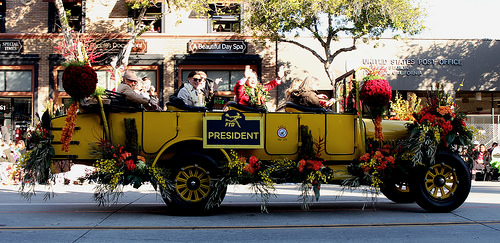

In [9]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[0]))

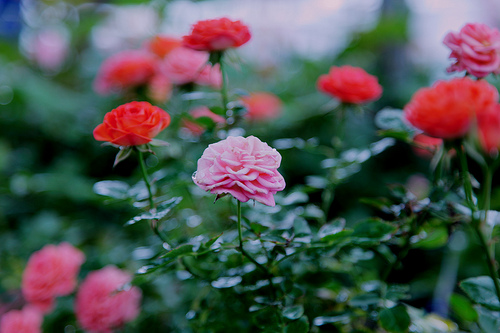

In [10]:
roses = list(data_dir.glob('roses/*'))
PIL.Image.open(str(roses[1]))

## `tf.keras.preprocessing`을 사용하여 로드하기

`tf.keras.preprocessing.image_dataset_from_directory`를 사용하여 이러한 이미지를 디스크에서 로드해 보겠습니다.

참고: 이 섹션에 소개된 Keras Preprocesing 유틸리티 및 레이어는 현재 실험 중이며 변경될 수 있습니다.

### 데이터세트 만들기

로더를 위해 일부 매개변수를 정의합니다.

In [11]:
batch_size = 32
img_height = 180
img_width = 180

모델을 개발할 때 검증 분할을 사용하는 것이 좋습니다. 이미지의 80%를 훈련에 사용하고 20%를 유효성 검사에 사용합니다.

In [12]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


2022-06-07 17:08:18.885105: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


이러한 데이터세트의 `class_names` 속성에서 클래스 이름을 찾을 수 있습니다.

In [14]:
class_names = train_ds.class_names
print(class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


### 데이터 시각화하기

훈련 데이터세트의 처음 9개 이미지는 다음과 같습니다.

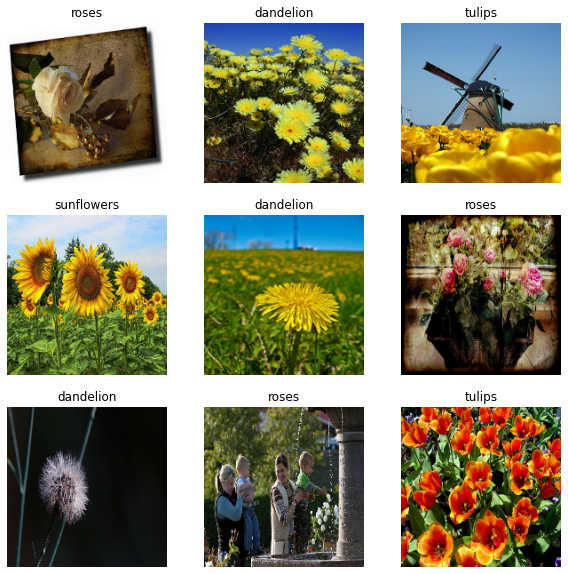

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

이러한 데이터세트를 사용하는 모델을 `model.fit`(이 튜토리얼의 뒷부분에 표시)에 전달하여 모델을 훈련할 수 있습니다. 원하는 경우, 데이터세트를 수동으로 반복하고 이미지 배치를 검색할 수도 있습니다.

In [16]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


`image_batch`는 `(32, 180, 180, 3)` 형상의 텐서이며, `180x180x3` 형상의 32개 이미지 묶음으로 되어 있습니다(마지막 차원은 색상 채널 RGB를 나타냄). `label_batch`는 형상 `(32,)`의 텐서이며 32개 이미지에 해당하는 레이블입니다.


참고: 이들 텐서 중 하나에서 `.numpy()`를 호출하여 `numpy.ndarray`로 변환할 수 있습니다.

### 데이터 표준화하기


RGB 채널 값은 `[0, 255]` 범위에 있습니다. 이것은 신경망에 이상적이지 않습니다. 일반적으로 입력 값을 작게 만들어야 합니다. 여기서는 `tf.keras.layers.experimental.preprocessing.Rescaling` 레이어를 사용하여 `[0, 1]` 범위에 있도록 값을 표준화합니다.

In [17]:
normalization_layer = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)

이 레이어를 사용하는 방법에는 두 가지가 있습니다. map을 호출하여 데이터세트에 레이어를 적용할 수 있습니다.

In [18]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.0 0.96902645


또는 모델 정의 내에 레이어를 포함하여 배포를 단순화할 수 있습니다. 여기서는 두 번째 접근법을 사용할 것입니다.

참고: 픽셀 값을 `[-1,1]`으로 조정하려면 대신 `Rescaling(1./127.5, offset=-1)`를 작성할 수 있습니다.

참고: 이전에 `tf.keras.preprocessing.image_dataset_from_directory`의 `image_size` 인수를 사용하여 이미지 크기를 조정했습니다. 모델에 크기 조정 논리를 포함하려면 `tf.keras.layers.experimental.preprocessing.Resizing` 레이어를 대신 사용할 수 있습니다.


### 성능을 위한 데이터세트 구성하기

버퍼링된 프리페치를 사용하여 I/O를 차단하지 않고 디스크에서 데이터를 생성할 수 있도록 하겠습니다. 데이터를 로드할 때 다음 두 가지 중요한 메서드를 사용해야 합니다.

`.cache()`는 첫 번째 epoch 동안 디스크에서 이미지를 로드한 후 이미지를 메모리에 유지합니다. 이렇게 하면 모델을 훈련하는 동안 데이터세트가 병목 상태가 되지 않습니다. 데이터세트가 너무 커서 메모리에 맞지 않는 경우, 이 메서드를 사용하여 성능이 높은 온디스크 캐시를 생성할 수도 있습니다.

`.prefetch()`는 훈련 중에 데이터 전처리 및 모델 실행과 겹칩니다.

관심 있는 독자는 [데이터 성능 가이드](https://www.tensorflow.org/guide/data_performance#prefetching)에서 두 가지 메서드와 디스크에 데이터를 캐시하는 방법에 대해 자세히 알아볼 수 있습니다.

In [19]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### 모델 훈련하기

완전성을 위해 준비한 데이터세트를 사용하여 간단한 모델을 훈련하는 방법을 보여줍니다. 이 모델은 어떤 식으로든 조정되지 않았습니다. 목표는 방금 만든 데이터세트를 사용하여 역학을 보여주는 것입니다. 이미지 분류에 대한 자세한 내용은 이 [튜토리얼](https://www.tensorflow.org/tutorials/images/classification)을 참조하세요.

In [20]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

In [21]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

참고: 몇 개의 epoch에 대해서만 훈련하므로 이 튜토리얼은 빠르게 진행됩니다. 

In [22]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 45s 480ms/step - loss: 1.2858 - accuracy: 0.4455 - val_loss: 1.0738 - val_accuracy: 0.5695
Epoch 2/3
92/92 [==============================] - 42s 455ms/step - loss: 1.0550 - accuracy: 0.5797 - val_loss: 0.9961 - val_accuracy: 0.6131
Epoch 3/3
92/92 [==============================] - 44s 479ms/step - loss: 0.9372 - accuracy: 0.6230 - val_loss: 0.9181 - val_accuracy: 0.6403


참고: `model.fit`을 사용하는 대신 사용자 정의 훈련 루프를 작성할 수도 있습니다. 자세한 내용은 이 [튜토리얼](https://www.tensorflow.org/guide/keras/writing_a_training_loop_from_scratch)을 참조하세요.

검증 정확도가 훈련 정확도에 비해 낮으므로 모델이 과대적합되었음을 알 수 있습니다. 이 [튜토리얼](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit)에서 과대적합 및 이를 줄이는 방법에 대해 자세히 알아볼 수 있습니다.

## 미세 제어를 위해 `tf.data` 사용하기

위의 `tf.keras.preprocessing` 유틸리티는 이미지의 디렉토리에서 `tf.data.Dataset`을 작성하는 편리한 방법입니다. 보다 세밀한 제어를 위해 `tf.data`을 사용하여 자체 입력 파이프라인을 작성할 수 있습니다. 이 섹션에서는 이전에 다운로드한 TGZ 파일의 파일 경로부터 시작하여 이를 수행하는 방법을 보여줍니다.

In [23]:
list_ds = tf.data.Dataset.list_files(str(data_dir/'*/*'), shuffle=False)
list_ds = list_ds.shuffle(image_count, reshuffle_each_iteration=False)

In [24]:
for f in list_ds.take(5):
  print(f.numpy())

b'/Users/administrator/.keras/datasets/flower_photos/tulips/2243427551_809b603992_z.jpg'
b'/Users/administrator/.keras/datasets/flower_photos/dandelion/4944731313_023a0508fd_n.jpg'
b'/Users/administrator/.keras/datasets/flower_photos/tulips/14054827092_f359f5fcbd_m.jpg'
b'/Users/administrator/.keras/datasets/flower_photos/tulips/3510294699_bc4c72cb7d_n.jpg'
b'/Users/administrator/.keras/datasets/flower_photos/tulips/13979840624_28466cb3ec_n.jpg'


파일의 트리 구조를 사용하여 `class_names` 목록을 컴파일할 수 있습니다.

In [25]:
class_names = np.array(sorted([item.name for item in data_dir.glob('*') if item.name != "LICENSE.txt"]))
print(class_names)

['daisy' 'dandelion' 'roses' 'sunflowers' 'tulips']


데이터세트를 훈련 및 검증으로 분할합니다.

In [26]:
val_size = int(image_count * 0.2)
train_ds = list_ds.skip(val_size)
val_ds = list_ds.take(val_size)

다음과 같이 각 데이터세트의 길이를 볼 수 있습니다.

In [27]:
print(tf.data.experimental.cardinality(train_ds).numpy())
print(tf.data.experimental.cardinality(val_ds).numpy())

2936
734


파일 경로를 `(img, label)` 쌍으로 변환하는 간단한 함수를 작성합니다.

In [28]:
def get_label(file_path):
  # convert the path to a list of path components
  parts = tf.strings.split(file_path, os.path.sep)
  # The second to last is the class-directory
  one_hot = parts[-2] == class_names
  # Integer encode the label
  return tf.argmax(one_hot)

In [29]:
def decode_img(img):
  # convert the compressed string to a 3D uint8 tensor
  img = tf.io.decode_jpeg(img, channels=3)
  # resize the image to the desired size
  return tf.image.resize(img, [img_height, img_width])

In [30]:
def process_path(file_path):
  label = get_label(file_path)
  # load the raw data from the file as a string
  img = tf.io.read_file(file_path)
  img = decode_img(img)
  return img, label

`Dataset.map`을 사용하여 `image, label` 쌍의 데이터세트를 작성합니다.

In [31]:
# Set `num_parallel_calls` so multiple images are loaded/processed in parallel.
train_ds = train_ds.map(process_path, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(process_path, num_parallel_calls=AUTOTUNE)

In [32]:
for image, label in train_ds.take(1):
  print("Image shape: ", image.numpy().shape)
  print("Label: ", label.numpy())

Image shape:  (180, 180, 3)
Label:  0


### 성능을 위한 데이터세트 구성하기

이 데이터세트로 모델을 훈련하려면 데이터에 대해 다음이 필요합니다.

- 잘 섞는다.
- 배치 처리한다.
- 가능한 빨리 배치를 사용할 수 있어야 한다.

이러한 기능은 `tf.data` API를 사용하여 추가할 수 있습니다. 자세한 내용은 [입력 파이프라인 성능](../../guide/performance/datasets) 가이드를 참조하세요.

In [33]:
def configure_for_performance(ds):
  ds = ds.cache()
  ds = ds.shuffle(buffer_size=1000)
  ds = ds.batch(batch_size)
  ds = ds.prefetch(buffer_size=AUTOTUNE)
  return ds

train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)

### 데이터 시각화하기

이 데이터세트를 이전에 작성한 데이터세트와 유사하게 시각화할 수 있습니다.

2022-06-07 17:11:40.300826: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


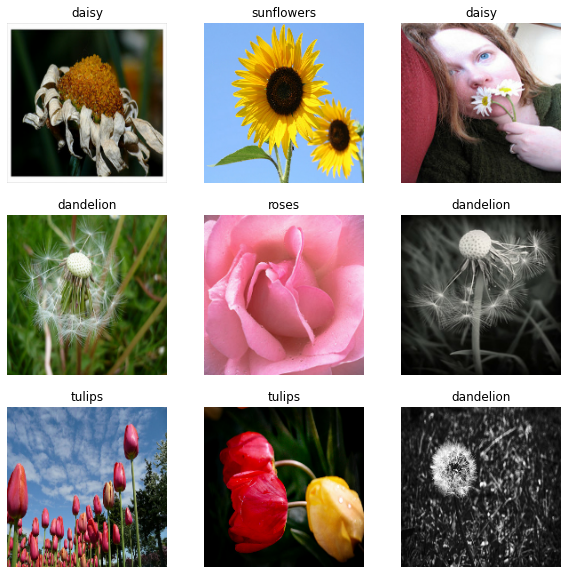

In [34]:
image_batch, label_batch = next(iter(train_ds))

plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].numpy().astype("uint8"))
  label = label_batch[i]
  plt.title(class_names[label])
  plt.axis("off")

### 모델 계속 훈련하기

위의 `keras.preprocessing`에 의해 작성된 것과 유사한 `tf.data.Dataset`를 수동으로 빌드했습니다. 이것으로 모델 훈련을 계속할 수 있습니다. 이전과 마찬가지로 실행 시간을 짧게 유지하기 위해 몇 개의 epoch 동안만 훈련합니다.

In [35]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=3
)

Epoch 1/3
92/92 [==============================] - 43s 456ms/step - loss: 0.8668 - accuracy: 0.6693 - val_loss: 0.8187 - val_accuracy: 0.6880
Epoch 2/3
92/92 [==============================] - 42s 456ms/step - loss: 0.6744 - accuracy: 0.7483 - val_loss: 0.7953 - val_accuracy: 0.6962
Epoch 3/3
92/92 [==============================] - 45s 489ms/step - loss: 0.5309 - accuracy: 0.8076 - val_loss: 0.7641 - val_accuracy: 0.7125


## TensorFlow 데이터세트 사용하기

이 튜토리얼에서는 지금까지 디스크에서 데이터를 로드하는 데 중점을 두었습니다. [TensorFlow 데이터세트](https://www.tensorflow.org/datasets)에서 다운로드하기 쉬운 대규모 데이터세트 [카탈로그](https://www.tensorflow.org/datasets)를 탐색하여 사용할 데이터세트를 찾을 수도 있습니다. 이전에 Flowers 데이터세트를 디스크에서 로드했으므로 TensorFlow 데이터세트로 가져오는 방법을 살펴보겠습니다. 

TensorFlow 데이터세트를 사용하여 꽃 [데이터세트](https://www.tensorflow.org/datasets/catalog/tf_flowers)를 다운로드합니다.

In [36]:
(train_ds, val_ds, test_ds), metadata = tfds.load(
    'tf_flowers',
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'],
    with_info=True,
    as_supervised=True,
)

2022-06-07 17:14:06.853767: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".



Dataset tf_flowers downloaded and prepared to ~/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


꽃 데이터세트에는 5개의 클래스가 있습니다.

In [37]:
num_classes = metadata.features['label'].num_classes
print(num_classes)

5


데이터세트에서 이미지를 검색합니다.

2022-06-07 17:14:39.493431: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


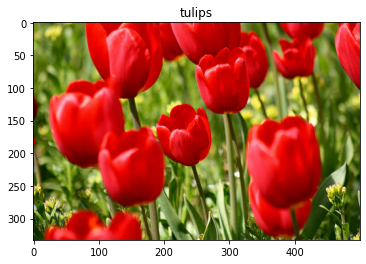

In [38]:
get_label_name = metadata.features['label'].int2str

image, label = next(iter(train_ds))
_ = plt.imshow(image)
_ = plt.title(get_label_name(label))

이전과 마찬가지로, 성능을 위해 각 데이터세트를 일괄 처리, 셔플 및 구성해야 합니다.

In [39]:
train_ds = configure_for_performance(train_ds)
val_ds = configure_for_performance(val_ds)
test_ds = configure_for_performance(test_ds)

[데이터 강화](https://www.tensorflow.org/tutorials/images/data_augmentation) 가이드를 방문하여 꽃 데이터세트 및 TensorFlow 데이터세트를 처리하는 전체 예제를 찾을 수 있습니다.

## 다음 단계

이 튜토리얼에서는 디스크에서 이미지를 로드하는 두 가지 방법을 보여주었습니다. 먼저 Keras 전처리 레이어 및 유틸리티를 사용하여 이미지 데이터세트를 로드하고 전처리하는 방법을 배웠습니다. 다음으로, `tf.data`를 사용하여 처음부터 입력 파이프라인을 작성하는 방법을 배웠습니다. 다음 단계로 이 [튜토리얼](https://www.tensorflow.org/tutorials/images/data_augmentation)을 방문하여 데이터 기능 보강을 추가하는 방법을 학습할 수 있습니다. `tf.data`에 대한 자세한 내용은 [tf.data: Build TensorFlow 입력 파이프라인](https://www.tensorflow.org/guide/data) 가이드를 참조하세요.